In [1]:
import typing

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from pandas import Grouper as tg

import pangho

import interpretable as inter
import interpretable_linear_data as interData

import tqdm.auto as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.metrics import r2_score

In [2]:
# load clean data
#df = pd.read_csv('january_data_2019.csv', index_col=0)
%store -r dataf

In [3]:
# we store the desired data
mid = dataf['mid'][:2000000].copy()
returns = dataf['returns'][:2000000].copy()
qty_signed = dataf['qty_signed'][:2000000].copy()
epsilons = qty_signed.apply(lambda x: np.sign(x)).copy()

In [4]:
# we set the learning lag parameter
N = len(dataf)
max_lag = 1000

In [5]:
def f2(v,a,b):
    return a*np.power(v,-b)
def f3(v,a,b):
    return a*v+b

In [6]:
# trades autcovariance 
acf_epsilons_USB = inter.autocovariance(epsilons.values , max_lag)

# curve fitting 
params2, cov = curve_fit(f2, np.arange(1,max_lag+1), acf_epsilons_USB[1:] )


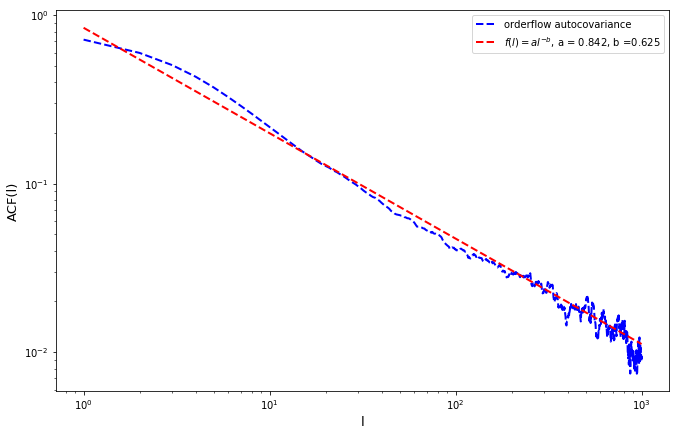

In [7]:
# plot
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

appro = f2(np.arange(1,N+1), *params2)
ax1.plot(np.arange(1,max_lag+1), acf_epsilons_USB[1:], '--b', linewidth=2, label ='orderflow autocovariance')
ax1.plot(np.arange(1,max_lag+1), appro[:max_lag], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params2[0])[:5] + ', b =' + str(params2[1])[:5] )
ax1.set_xlabel('l', fontsize=13)
ax1.set_ylabel('ACF(l)', fontsize=13)
ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_xlim((0,1000))

plt.savefig('graphs_10YUSB/order_flow_autocovariance_function_10YUSB.png')
#plt.savefig('graphs_SPMINI/order_flow_autocovariance_function_SPMINI.png')
plt.show()

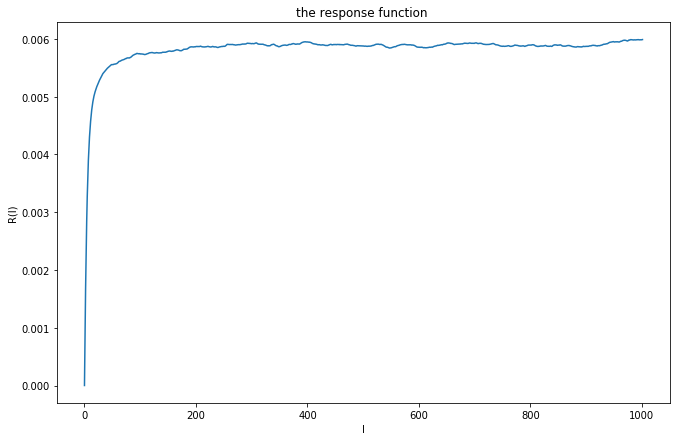

In [8]:
# response function 

Res_USB = inter.response_function(epsilons.values, mid.values, max_lag+1)

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(Res_USB)
ax1.set_title('the response function ')
ax1.set_xlabel('l')
ax1.set_ylabel('R(l)')

plt.savefig('graphs_10YUSB/response_function_10YUSB.png')
#plt.savefig('graphs_SPMINI/response_function_SPMINI.png')

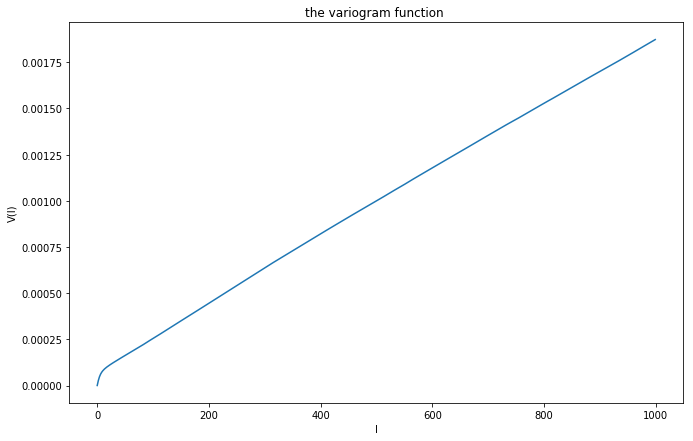

In [9]:
# the variogram
Vario_USB = inter.variogram2(mid.values, max_lag)

# plot 
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(Vario_USB)

ax1.set_title('the variogram function ')
ax1.set_xlabel('l')
ax1.set_ylabel('V(l)')
#ax1.legend()


plt.savefig('graphs_10YUSB/variogram_function_10YUSB.png')
#plt.savefig('graphs_SPMINI/variogram_function_SPMINI.png')

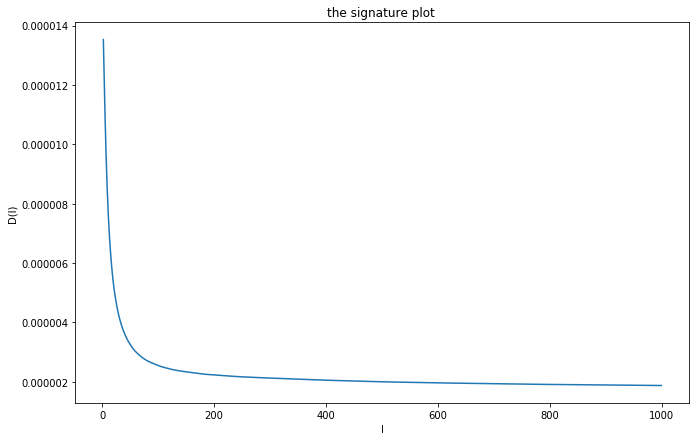

In [10]:
# signature plot 

signature_plot = Vario_USB[1:]/np.arange(1,len(Vario_USB))

# plot 
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(signature_plot[1:])
ax1.set_title('the signature plot ')
ax1.set_xlabel('l')
ax1.set_ylabel('D(l)')
#ax1.legend()

plt.savefig('graphs_10YUSB/signature_plot_10YUSB.png')
#plt.savefig('graphs_SPMINI/signature_plot_SPMINI.png')

In [11]:
# we can start the kernel regression

# linear regression

# we define the regression matrix

L = 500

A = inter.regression_matrix(epsilons.values, L-1)
#row_std = A.std(axis=1)
#new_matrix = A #/ row_std[:, np.newaxis]
Y = returns.values[L-1:]

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(A, Y)
K_star = reg.coef_
K_star = pd.Series(K_star)

G_star_USB = pd.concat((pd.Series([0]), K_star.cumsum()))

# problem inversion

#S = Res.diff().dropna() # do not work it is the proof that the model is wrong 
S = inter.sign_return_correlation2(returns, epsilons, len(Res_USB))

K_approx = inter.problem_inversion(S, np.linalg.inv(inter.covariance_matrix(acf_epsilons_USB, L)), L)

G_approx_USB = pd.concat((pd.Series([0]), K_approx.cumsum()))

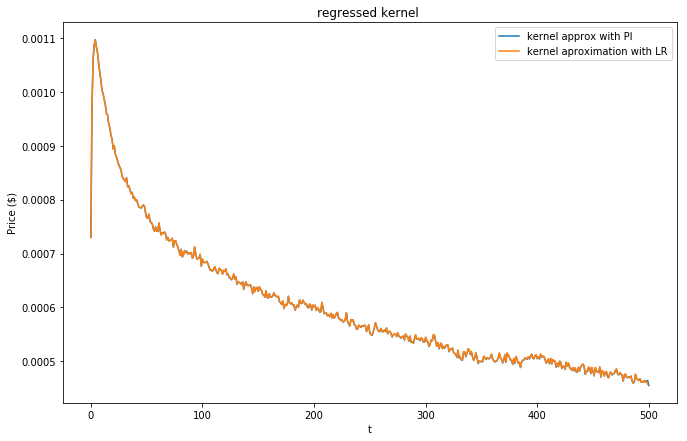

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(G_approx_USB[1:], label = 'kernel approx with PI')
ax1.plot(G_star_USB[1:], label = 'kernel aproximation with LR')
ax1.set_title('regressed kernel ')
ax1.set_xlabel('t')
ax1.set_ylabel('Price ($)')
#ax1.set_xlim((1,500))
ax1.legend()

plt.savefig('graphs_10YUSB/linear_regression_kernels_10YUSB.png')
#plt.savefig('graphs_SPMINI/linear_regression_kernels_SPMINI.png')

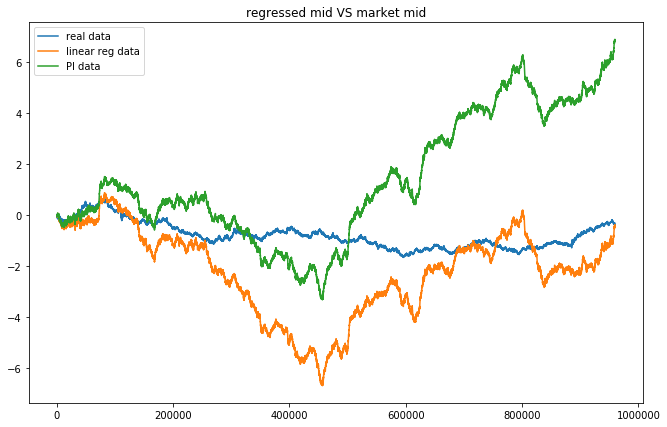

In [13]:
noise = np.random.normal(0,0, len(returns))
m = 10000
new_data_reg = pd.Series(reg.predict(A))
new_data_PI = pd.Series(inter.generator(epsilons.values, G_approx_USB, noise, L-1)).loc[L-1:]
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(Y.cumsum(), label = 'real data')
ax1.plot( new_data_reg.values.cumsum(), label = 'linear reg data' )
ax1.plot( new_data_PI.values.cumsum(), label = 'PI data' )
ax1.set_title('regressed mid VS market mid')
ax1.legend()

plt.savefig('graphs_10YUSB/linear_mid_comparison_10YUSB.png')
#plt.savefig('graphs_SPMINI/linear_mid_comparison_SPMINI.png')

In [14]:
synthetic_variogram_Gstar_USB_approx_epsilons = inter.variogram2(new_data_reg.cumsum())
R2_Gstar_USB_approx_epsilons = inter.R2(Y, new_data_reg)
% store synthetic_variogram_Gstar_USB_approx_epsilons
% store new_data_reg
% store R2_Gstar_USB_approx_epsilons


Stored 'synthetic_variogram_Gstar_USB_approx_epsilons' (Series)
Stored 'new_data_reg' (Series)
Stored 'R2_Gstar_USB_approx_epsilons' (Series)


In [15]:
inter.R2(Y, new_data_reg)

0    0.063015
dtype: float64

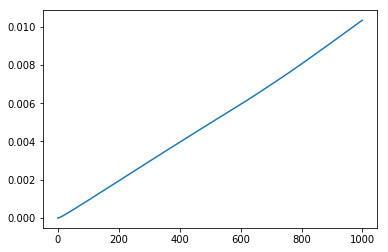

In [16]:
plt.plot(synthetic_variogram_Gstar_USB_approx_epsilons)

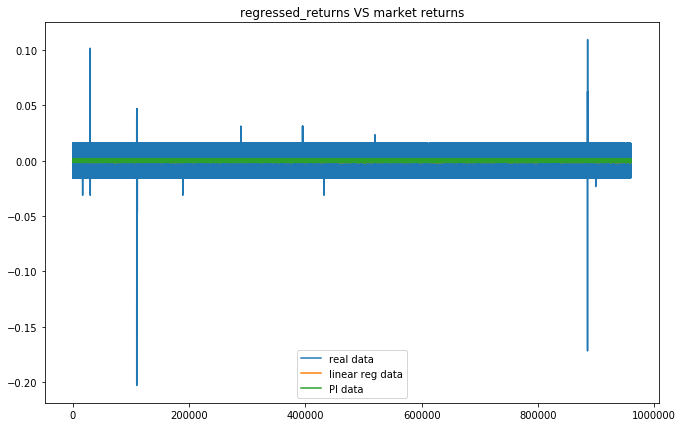

In [18]:
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

ax1.plot(Y, label = 'real data')
ax1.plot(  (new_data_reg), label = 'linear reg data' )
ax1.plot( (new_data_PI).values, label = 'PI data' )
ax1.set_title('regressed_returns VS market returns')
ax1.legend()

#plt.savefig('graphs_10YUSB/linear_returns_comparison_10YUSB.png')
plt.savefig('graphs_SPMINI/linear_returns_comparison_SPMINI.png')

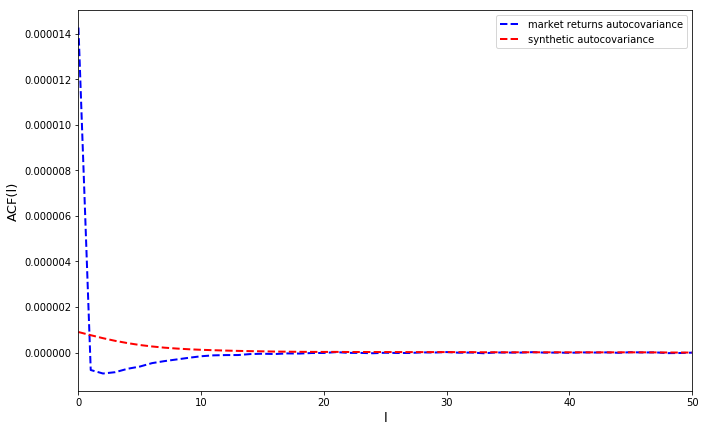

In [19]:
# plot
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])

appro = f2(np.arange(1,N+1), *params2)
ax1.plot(inter.autocovariance(Y, max_lag), '--b', linewidth=2, label ='market returns autocovariance')
ax1.plot(inter.autocovariance(new_data_reg.values, max_lag), '--r', linewidth=2, label ='synthetic autocovariance')
ax1.set_xlabel('l', fontsize=13)
ax1.set_ylabel('ACF(l)', fontsize=13)
ax1.legend()
#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlim((0,50))

plt.savefig('graphs_10YUSB/linear_returns_autocovariance_function_10YUSB.png')
#plt.savefig('graphs_SPMINI/linear_returns_autocovariance_function_SPMINI.png')

plt.show()

$\underline{\text{Single-layer NN} }$

In [20]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import NonNeg 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn import preprocessing


In [21]:
# we aplly the kernel constraints
class NonNegativeCumsum(tf.keras.constraints.Constraint):

    def __call__(self, w):
        return w * tf.cast(tf.math.greater_equal(tf.math.cumsum(w), 0.), w.dtype)
    
def plot_loss(ax, history):
    ax.semilogy(history.history['loss'], label='loss')
    ax.semilogy(history.history['val_loss'], label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    ax.legend()
    ax.grid(True)

In [22]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0001)
#optimizer = tf.optimizers.Adam(learning_rate = 0.0001)
#optimizer = tf.keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.01)
batch_size = int(N/1000)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)

In [23]:
def normalize_rows(x: np.ndarray):
    return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)

In [24]:
train_norm = pd.DataFrame(A)

linear_model2 = Sequential()
linear_model2.add(tf.keras.layers.Dense(units = 1, 
                                        kernel_constraint = NonNegativeCumsum(), 
                                        use_bias = False,
                                        dtype = 'float64')
                        )


linear_model2.compile(optimizer = optimizer,
                             loss = "mean_squared_error")
     
history2 = linear_model2.fit(train_norm,
                               Y,
                               epochs = 200,
                               # We do not suppress logging.
                               verbose = 1,
                               # Calculate validation results on 30% of the training data.
                               validation_split = 0.3,
                               batch_size = batch_size,
                               callbacks = [callback]
                              )
linear_model2.summary()

Epoch 1/200
701/701 [==============================] - 2s 3ms/step - loss: 0.5181 - val_loss: 0.3803
Epoch 2/200
701/701 [==============================] - 1s 2ms/step - loss: 0.3027 - val_loss: 0.2568
Epoch 3/200
701/701 [==============================] - 1s 2ms/step - loss: 0.2140 - val_loss: 0.1947
Epoch 4/200
701/701 [==============================] - 1s 2ms/step - loss: 0.1654 - val_loss: 0.1587
Epoch 5/200
701/701 [==============================] - 1s 2ms/step - loss: 0.1385 - val_loss: 0.1323
Epoch 6/200
701/701 [==============================] - 1s 2ms/step - loss: 0.1148 - val_loss: 0.1078
Epoch 7/200
701/701 [==============================] - 1s 2ms/step - loss: 0.0950 - val_loss: 0.0858
Epoch 8/200
701/701 [==============================] - 1s 2ms/step - loss: 0.0753 - val_loss: 0.0742
Epoch 9/200
701/701 [==============================] - 1s 2ms/step - loss: 0.0642 - val_loss: 0.0603
Epoch 10/200
701/701 [==============================] - 1s 2ms/step - loss: 0.0506 - val_lo

Epoch 78/200
701/701 [==============================] - 1s 2ms/step - loss: 1.7379e-05 - val_loss: 1.7224e-05
Epoch 79/200
701/701 [==============================] - 1s 2ms/step - loss: 1.7114e-05 - val_loss: 1.6950e-05
Epoch 80/200
701/701 [==============================] - 1s 2ms/step - loss: 1.6871e-05 - val_loss: 1.6698e-05
Epoch 81/200
701/701 [==============================] - 1s 2ms/step - loss: 1.6647e-05 - val_loss: 1.6465e-05
Epoch 82/200
701/701 [==============================] - 1s 2ms/step - loss: 1.6440e-05 - val_loss: 1.6249e-05
Epoch 83/200
701/701 [==============================] - 1s 2ms/step - loss: 1.6248e-05 - val_loss: 1.6049e-05
Epoch 84/200
701/701 [==============================] - 1s 2ms/step - loss: 1.6069e-05 - val_loss: 1.5863e-05
Epoch 85/200
701/701 [==============================] - 1s 2ms/step - loss: 1.5903e-05 - val_loss: 1.5690e-05
Epoch 86/200
701/701 [==============================] - 1s 2ms/step - loss: 1.5748e-05 - val_loss: 1.5529e-05
Epoch 87/2

701/701 [==============================] - 1s 2ms/step - loss: 1.3513e-05 - val_loss: 1.3191e-05
Epoch 153/200
701/701 [==============================] - 1s 2ms/step - loss: 1.3511e-05 - val_loss: 1.3188e-05
Epoch 154/200
701/701 [==============================] - 1s 2ms/step - loss: 1.3509e-05 - val_loss: 1.3186e-05
Epoch 155/200
701/701 [==============================] - 1s 2ms/step - loss: 1.3507e-05 - val_loss: 1.3184e-05
Epoch 156/200
701/701 [==============================] - 1s 2ms/step - loss: 1.3505e-05 - val_loss: 1.3182e-05
Epoch 157/200
701/701 [==============================] - 1s 2ms/step - loss: 1.3503e-05 - val_loss: 1.3181e-05
Epoch 158/200
701/701 [==============================] - 1s 2ms/step - loss: 1.3502e-05 - val_loss: 1.3179e-05
Epoch 159/200
701/701 [==============================] - 1s 2ms/step - loss: 1.3500e-05 - val_loss: 1.3178e-05
Epoch 160/200
701/701 [==============================] - 1s 2ms/step - loss: 1.3498e-05 - val_loss: 1.3176e-05
Epoch 161/200
7

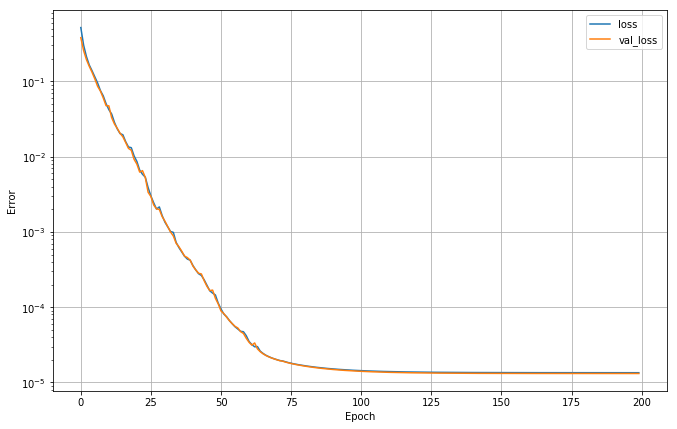

In [25]:
# we plot the loss on validation set and training set on each batch
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])
plot_loss(ax1, history2)
plt.savefig('graphs_10YUSB/NN2_loss_kernel_10YUSB.png')
#plt.savefig('graphs_SPMINI/NN2_loss_kernel_SPMINI.png')

In [26]:
GNN_approx_USB_epsilons = pd.concat((pd.Series([0]), pd.Series(linear_model2.layers[0].kernel.numpy().cumsum())))

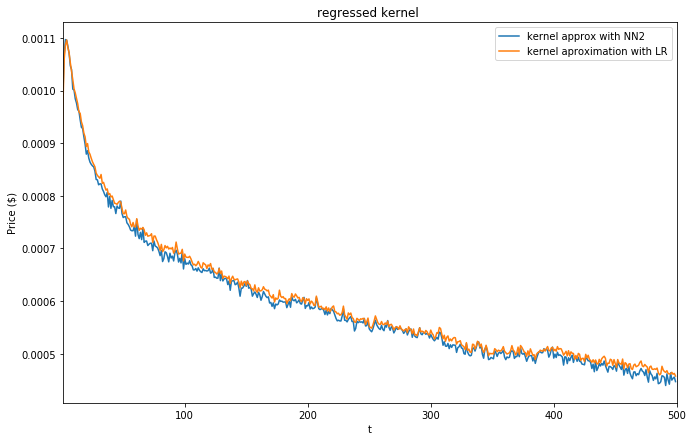

In [27]:
fig, (ax1) = plt.subplots(1, 1, figsize=[11, 7])
#GNN2_approx[1:]
#GNN1_approx[1:]
ax1.plot(GNN_approx_USB_epsilons[1:], label = 'kernel approx with NN2')
#ax1.plot(GNN1_approx[1:], label = 'kernel approx with NN1')
#ax1.plot(G_approx[1:], label = 'kernel approx with PI')
ax1.plot(G_star_USB[1:], label = 'kernel aproximation with LR')
ax1.set_title('regressed kernel ')
ax1.set_xlabel('t')
ax1.set_ylabel('Price ($)')
ax1.set_xlim((1,500))
#ax1.set_ylim((0,0.5))
ax1.legend()

plt.savefig('graphs_10YUSB/NN_regression_kernel_10YUSB.png')
#plt.savefig('graphs_SPMINI/NN_regression_kernel_SPMINI.png')

In [38]:
YNN2_pred = linear_model2.predict(A)
synthetic_variogram_GNN_approx_epsilons_USB = inter.variogram2(YNN2_pred.cumsum())

In [39]:
R2_GNN_USB_approx_epsilons = r2_score(Y, YNN2_pred.reshape((len(Y),-1)))
% store YNN2_pred

Stored 'YNN2_pred' (ndarray)


In [40]:
R2_GNN_USB_approx_epsilons

0.06261338662925242

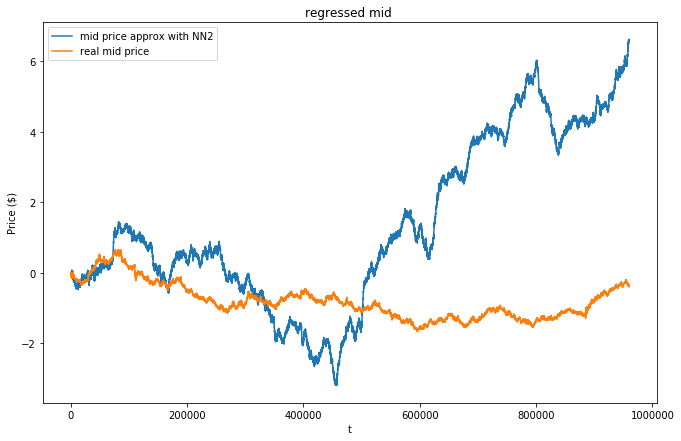

In [41]:
fig, (ax1) = plt.subplots(1, 1, figsize = [11, 7])

ax1.plot(YNN2_pred.cumsum(), label = 'mid price approx with NN2')
#ax1.plot(YLR_pred.cumsum(), label = 'mid price approx with reglin')
ax1.plot(Y.cumsum(), label = 'real mid price ')
ax1.set_title('regressed mid ')
ax1.set_xlabel('t')
ax1.set_ylabel('Price ($)')
#ax1.set_xlim((1,1000))
ax1.legend()

plt.savefig('graphs_10YUSB/mid_comparative_10YUSB.png')
#plt.savefig('graphs_SPMINI/mid_comparative_SPMINI.png')

In [42]:
G_star_USB_epsilons = G_star_USB

In [43]:
G_approx_USB_epsilons = G_approx_USB

In [44]:
YNN_USB_epsilons = YNN2_pred

In [45]:
YLR_approx_USB_epsilons = new_data_reg

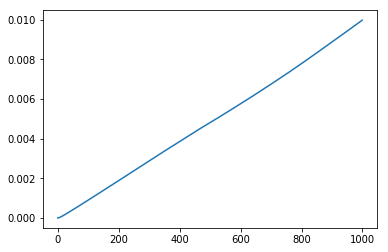

In [46]:
plt.plot(synthetic_variogram_GNN_approx_epsilons_USB)

In [47]:
# data to store:

# autocovariance
% store acf_epsilons_USB

# response
% store Res_USB

# signature plot + variogram
% store Vario_USB

# kernels
% store G_star_USB_epsilons
% store G_approx_USB_epsilons
% store GNN_approx_USB_epsilons

# synthetic variograms
% store synthetic_variogram_Gstar_USB_approx_epsilons
% store synthetic_variogram_GNN_approx_epsilons_USB

# R squared
% store R2_Gstar_USB_approx_epsilons
% store R2_GNN_USB_approx_epsilons

# synthetic returns
% store YNN_USB_epsilons
% store YLR_approx_USB_epsilons 

Stored 'acf_epsilons_USB' (Series)
Stored 'Res_USB' (Series)
Stored 'Vario_USB' (Series)
Stored 'G_star_USB_epsilons' (Series)
Stored 'G_approx_USB_epsilons' (Series)
Stored 'GNN_approx_USB_epsilons' (Series)
Stored 'synthetic_variogram_Gstar_USB_approx_epsilons' (Series)
Stored 'synthetic_variogram_GNN_approx_epsilons_USB' (Series)
Stored 'R2_Gstar_USB_approx_epsilons' (Series)
Stored 'R2_GNN_USB_approx_epsilons' (float64)
Stored 'YNN_USB_epsilons' (ndarray)
Stored 'YLR_approx_USB_epsilons' (Series)
